In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load and sort the dataset
data = pd.read_csv('combined_dataset.csv')
data_sorted = data.sort_values(by='Unnamed: 0')

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data_sorted, test_size=0.2, random_state=42)

# Select only numeric columns
train_data_numeric = train_data.select_dtypes(include=[np.number])
test_data_numeric = test_data.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = train_data_numeric.corr()

# Extract correlations with NASDAQ_Volatility and filter based on absolute value
nasdaq_volatility_correlations = correlation_matrix['NASDAQ_Volatility']
significant_correlations = nasdaq_volatility_correlations[abs(nasdaq_volatility_correlations) >= 0.05]
filtered_columns = significant_correlations.index.tolist()

# Filter the columns in the dataset based on significant correlations
train_data_filtered = train_data_numeric[filtered_columns]
test_data_filtered = test_data_numeric[filtered_columns]

# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Remove multicollinear variables
vif_data = calculate_vif(train_data_filtered.drop(columns=['NASDAQ_Volatility']))
while vif_data['VIF'].max() > 10:  # Adjust the threshold as necessary
    highest_vif = vif_data['VIF'].idxmax()
    train_data_filtered.drop(columns=vif_data.loc[highest_vif, 'feature'], inplace=True)
    test_data_filtered.drop(columns=vif_data.loc[highest_vif, 'feature'], inplace=True)
    vif_data = calculate_vif(train_data_filtered.drop(columns=['NASDAQ_Volatility']))

# Separate features and target variable for training and testing data
Y_train = train_data_filtered['NASDAQ_Volatility']
X_train = train_data_filtered.drop(columns=['NASDAQ_Volatility'])
Y_test = test_data_filtered['NASDAQ_Volatility']
X_test = test_data_filtered.drop(columns=['NASDAQ_Volatility'])

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train_pca, Y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test_pca)

# Calculate MSE and R-squared
mse = mean_squared_error(Y_test, Y_pred)
r_squared = model.score(X_test_pca, Y_test)

# Print the results
print("Mean Squared Error:", mse)
print("Number of PCA Components:", pca.n_components_)
print("R-squared:", r_squared)


/var/folders/j7/7h0t_w2s0s92kqx_qf491fgw0000gn/T/ipykernel_36796/2637035431.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_filtered.drop(columns=vif_data.loc[highest_vif, 'feature'], inplace=True)
/var/folders/j7/7h0t_w2s0s92kqx_qf491fgw0000gn/T/ipykernel_36796/2637035431.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_filtered.drop(columns=vif_data.loc[highest_vif, 'feature'], inplace=True)
/var/folders/j7/7h0t_w2s0s92kqx_qf491fgw0000gn/T/ipykernel_36796/2637035431.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

Mean Squared Error: 6.669625467166993e-08
Number of PCA Components: 31
R-squared: 0.28457165364004544


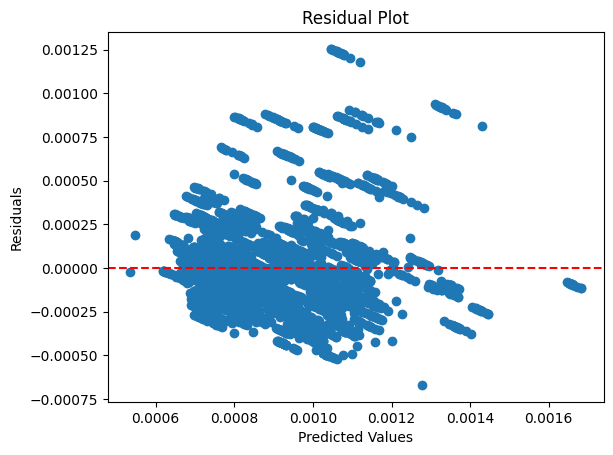

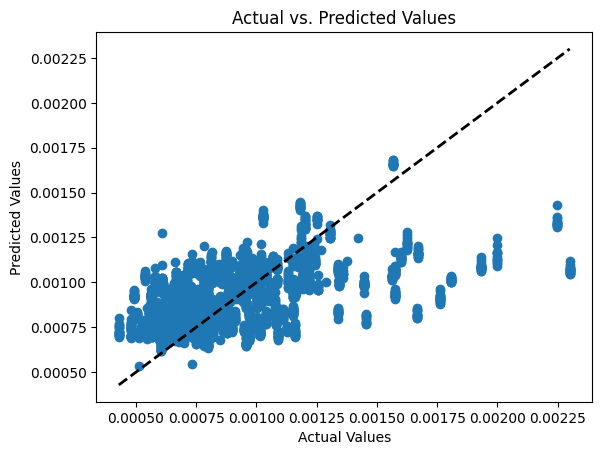

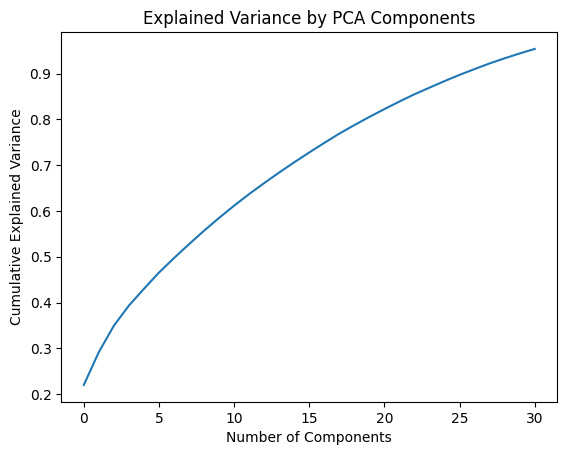

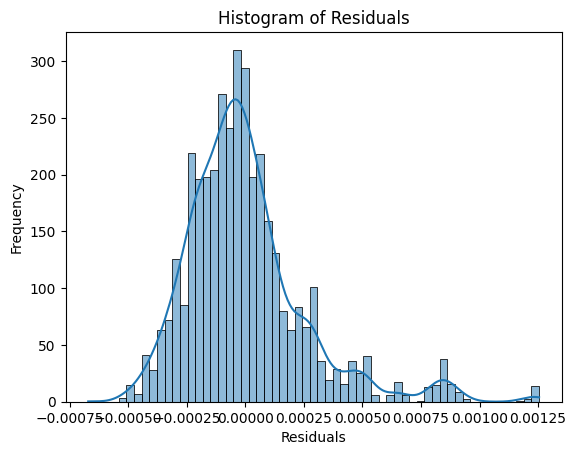

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residual Plot
residuals = Y_test - Y_pred
plt.scatter(Y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Comparison Plot
plt.scatter(Y_test, Y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.show()

# PCA Component Variance Plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

# Histogram of Residuals
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
